In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import os
import re

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


In [7]:
#Daten einlesen
RELPATH = '/home/ki-projekt/KI-Projekt/data/TennesseEastman/'

data = []
dataTE = []
index = 0
indexTE = 0

# Dateien einlesen ############# aktuelles Problem: die Daten werden nicht der Reihe nach eingelesen ############
for datei in os.listdir(RELPATH):
    filePath = os.path.join(RELPATH, datei)

    number_match = re.search(r'\d+', datei)
    if number_match:
        number = int(number_match.group())

        #print(f'Found file: {filePath}, Number: {number}')

        with open(filePath, 'r') as file:
            lines = file.read().splitlines()

            if 'te' in datei:
                while len(dataTE) <= number:
                    dataTE.append([])  # Füge neue Listen hinzu, wenn der Index größer als die Länge von dataTE ist
                dataTE[number] = np.transpose([list(map(float, line.split()[:52])) for line in lines])[:, :480]
            else:
                while len(data) <= number:
                    data.append([])  # Füge neue Listen hinzu, wenn der Index größer als die Länge von data ist
                temp_data = [list(map(float, line.split()[:480])) for line in lines]
                if len(temp_data) > 52:
                    data[number] = np.transpose(temp_data)
                else:
                    data[number] = temp_data

matrix_data = np.array(data)
matrix_dataTE = np.array(dataTE)

In [11]:
print(matrix_data.shape)
print(matrix_data.dtype)

print(matrix_dataTE.shape)
print(matrix_dataTE.dtype)

(22, 52, 480)
float64
(22, 52, 480)
float64


Text(0, 0.5, 'Werte')

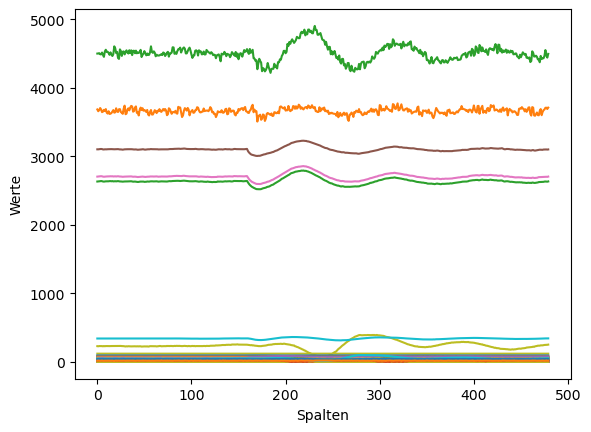

In [9]:
# Beispiel: Plot der ersten Zeile
# matrix_data[Fehler(-1), ]
plt.plot(np.transpose(matrix_dataTE[7]))
plt.xlabel('Spalten')
plt.ylabel('Werte')

In [12]:
training_data = []
test_data = []

for i in range(22):
      #label
      oneHotVector = np.eye(22)[i, :]
      fault_data = np.transpose(data[i] / np.max(data))
      fault_dataTE = np.transpose(dataTE[i] / np.max(dataTE))

      for k in range(480):
            training_data.append([fault_data[k], oneHotVector])
            test_data.append([fault_dataTE[k], oneHotVector])

x_train = []
y_train = []

x_test = []
y_test = []

for testvalues, label in training_data:
      x_train.append(testvalues)
      y_train.append(label)

for testvalues, label in test_data:
      x_test.append(testvalues)
      y_test.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


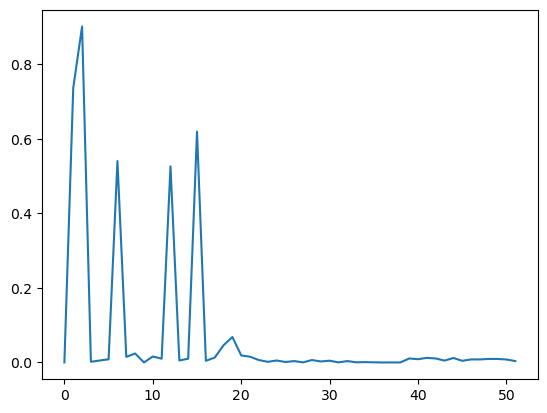

In [13]:
plt.plot(np.transpose(x_train[8]))
print(y_train[0])

In [14]:
# Annahme: my_data enthält deine Daten mit dem korrekten Verlauf in der ersten Spalte und den Fehlern in den folgenden Spalten
my_data = matrix_data 

In [ ]:
# Daten vorbereiten
X = my_data[:, 0].reshape(-1, 1)  # Eingangsdaten: Korrekter Verlauf
y = my_data[:, 1:]  # Zielvariablen: Fehlerklassen

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [10560, 22]

In [ ]:
# Skalierung der Daten
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(X_test)

NameError: name 'X_test' is not defined

In [ ]:
# Modell erstellen (LSTM)
model = Sequential()
model.add(LSTM(64, input_shape=(x_train_scaled.shape[1], 1)))
model.add(Dense(22, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2023-12-11 07:57:19.619799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-11 07:57:19.622024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-11 07:57:19.623835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
# Modell trainieren
history = model.fit(x_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

In [ ]:
# Modellbewertung
train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)[1]
test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)[1]

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
# Confusion Matrix
y_pred = model.predict_classes(X_test_scaled)
y_true = [i.argmax() for i in y_test]
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

In [ ]:
# Classification Report
class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)